# Análisis de Hipótesis 3: Brecha de Edad entre Cónyuges
## Evolución de la Diferencia de Edad en Matrimonios en Guatemala (2011-2021)

---

### 🔬 Hipótesis

**"La diferencia de edad entre cónyuges se ha reducido con el tiempo, reflejando mayor equidad de género y cambios en patrones de emparejamiento, con parejas más cercanas en edad que hace una década"**

---

### 📋 Objetivos del Análisis

1. **Calcular diferencia de edad** - (Edad Hombre - Edad Mujer) por año
2. **Análisis de tendencia temporal** - Evolución de la brecha
3. **Regresión lineal** - Modelar la tendencia de reducción
4. **Comparación 2011 vs 2021** - Cambio en la década
5. **Análisis de distribuciones** - Patrones de emparejamiento
6. **Clustering** - Identificar grupos de parejas por diferencia de edad

---

## 1. Configuración Inicial y Carga de Librerías

In [42]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Librerías para análisis estadístico
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind, pearsonr, spearmanr, norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Librerías para clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Configuración
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ Librerías cargadas correctamente")

✓ Librerías cargadas correctamente


## 2. Carga y Preparación de Datos

In [43]:
# Cargar dataset de matrimonios
matrimonios = pd.read_csv('mat_full.csv', encoding='utf-8')

print(f"✓ Matrimonios cargados: {matrimonios.shape[0]:,} registros, {matrimonios.shape[1]} variables")
print(f"\nColumnas relevantes:")
print([col for col in matrimonios.columns if 'EDAD' in col or 'AÑO' in col])

✓ Matrimonios cargados: 752,264 registros, 15 variables

Columnas relevantes:
['AÑOREG', 'EDADHOM', 'EDADMUJ']


### 2.1 Limpieza y Cálculo de Diferencia de Edad

In [44]:
# Convertir columnas de edad a tipo numérico
matrimonios['EDADHOM'] = pd.to_numeric(matrimonios['EDADHOM'], errors='coerce')
matrimonios['EDADMUJ'] = pd.to_numeric(matrimonios['EDADMUJ'], errors='coerce')

# Filtrar solo registros con edades válidas
mat_clean = matrimonios[
    (matrimonios['EDADHOM'].notna()) & 
    (matrimonios['EDADMUJ'].notna()) &
    (matrimonios['EDADHOM'].between(15, 100)) &
    (matrimonios['EDADMUJ'].between(14, 100))
].copy()

print(f"✓ Datos limpios: {len(mat_clean):,} registros ({(len(mat_clean)/len(matrimonios)*100):.2f}% del total)")

# Calcular diferencia de edad (Hombre - Mujer)
mat_clean['DIFERENCIA_EDAD'] = mat_clean['EDADHOM'] - mat_clean['EDADMUJ']

# Calcular edad promedio de la pareja
mat_clean['EDAD_PROMEDIO'] = (mat_clean['EDADHOM'] + mat_clean['EDADMUJ']) / 2

print(f"\n✓ Variables calculadas:")
print(f"  DIFERENCIA_EDAD = EDADHOM - EDADMUJ")
print(f"  EDAD_PROMEDIO = (EDADHOM + EDADMUJ) / 2")

✓ Datos limpios: 751,419 registros (99.89% del total)

✓ Variables calculadas:
  DIFERENCIA_EDAD = EDADHOM - EDADMUJ
  EDAD_PROMEDIO = (EDADHOM + EDADMUJ) / 2


### 2.2 Exploración Inicial de la Diferencia de Edad

In [45]:
print("📊 ESTADÍSTICAS GENERALES DE DIFERENCIA DE EDAD")
print("="*80)
print(f"\nPromedio: {mat_clean['DIFERENCIA_EDAD'].mean():.2f} años")
print(f"Mediana: {mat_clean['DIFERENCIA_EDAD'].median():.2f} años")
print(f"Desviación estándar: {mat_clean['DIFERENCIA_EDAD'].std():.2f} años")
print(f"Mínimo: {mat_clean['DIFERENCIA_EDAD'].min():.0f} años")
print(f"Máximo: {mat_clean['DIFERENCIA_EDAD'].max():.0f} años")

# Percentiles
print(f"\nPercentiles:")
print(f"  P25: {mat_clean['DIFERENCIA_EDAD'].quantile(0.25):.2f} años")
print(f"  P50 (Mediana): {mat_clean['DIFERENCIA_EDAD'].quantile(0.50):.2f} años")
print(f"  P75: {mat_clean['DIFERENCIA_EDAD'].quantile(0.75):.2f} años")
print(f"  P90: {mat_clean['DIFERENCIA_EDAD'].quantile(0.90):.2f} años")

# Categorizar diferencias
print(f"\n📈 DISTRIBUCIÓN DE DIFERENCIAS:")
print(f"  Mujer mayor (< 0): {(mat_clean['DIFERENCIA_EDAD'] < 0).sum():,} ({(mat_clean['DIFERENCIA_EDAD'] < 0).mean()*100:.2f}%)")
print(f"  Misma edad (0): {(mat_clean['DIFERENCIA_EDAD'] == 0).sum():,} ({(mat_clean['DIFERENCIA_EDAD'] == 0).mean()*100:.2f}%)")
print(f"  Hombre mayor (> 0): {(mat_clean['DIFERENCIA_EDAD'] > 0).sum():,} ({(mat_clean['DIFERENCIA_EDAD'] > 0).mean()*100:.2f}%)")
print(f"\nDe los casos donde el hombre es mayor:")
print(f"  1-3 años: {((mat_clean['DIFERENCIA_EDAD'] > 0) & (mat_clean['DIFERENCIA_EDAD'] <= 3)).sum():,} ({((mat_clean['DIFERENCIA_EDAD'] > 0) & (mat_clean['DIFERENCIA_EDAD'] <= 3)).mean()*100:.2f}%)")
print(f"  4-6 años: {((mat_clean['DIFERENCIA_EDAD'] > 3) & (mat_clean['DIFERENCIA_EDAD'] <= 6)).sum():,} ({((mat_clean['DIFERENCIA_EDAD'] > 3) & (mat_clean['DIFERENCIA_EDAD'] <= 6)).mean()*100:.2f}%)")
print(f"  7-10 años: {((mat_clean['DIFERENCIA_EDAD'] > 6) & (mat_clean['DIFERENCIA_EDAD'] <= 10)).sum():,} ({((mat_clean['DIFERENCIA_EDAD'] > 6) & (mat_clean['DIFERENCIA_EDAD'] <= 10)).mean()*100:.2f}%)")
print(f"  >10 años: {(mat_clean['DIFERENCIA_EDAD'] > 10).sum():,} ({(mat_clean['DIFERENCIA_EDAD'] > 10).mean()*100:.2f}%)")

📊 ESTADÍSTICAS GENERALES DE DIFERENCIA DE EDAD

Promedio: 3.00 años
Mediana: 2.00 años
Desviación estándar: 5.92 años
Mínimo: -50 años
Máximo: 74 años

Percentiles:
  P25: 0.00 años
  P50 (Mediana): 2.00 años
  P75: 5.00 años
  P90: 9.00 años

📈 DISTRIBUCIÓN DE DIFERENCIAS:
  Mujer mayor (< 0): 166,036 (22.10%)
  Misma edad (0): 68,298 (9.09%)
  Hombre mayor (> 0): 517,085 (68.81%)

De los casos donde el hombre es mayor:
  1-3 años: 227,293 (30.25%)
  4-6 años: 146,536 (19.50%)
  7-10 años: 82,493 (10.98%)
  >10 años: 60,763 (8.09%)


## 3. Análisis de Tendencia Temporal

Analizamos cómo ha evolucionado la diferencia de edad a lo largo de los años.

### 3.1 Agregación por Año

In [46]:
# Agrupar por año y calcular estadísticas
tendencia_anual = mat_clean.groupby('AÑOREG').agg({
    'DIFERENCIA_EDAD': ['mean', 'median', 'std', 'min', 'max', 'count'],
    'EDADHOM': ['mean'],
    'EDADMUJ': ['mean']
}).reset_index()

# Aplanar nombres de columnas
tendencia_anual.columns = ['_'.join(col).strip('_') for col in tendencia_anual.columns.values]
tendencia_anual.rename(columns={
    'AÑOREG': 'Año',
    'DIFERENCIA_EDAD_mean': 'Dif_Media',
    'DIFERENCIA_EDAD_median': 'Dif_Mediana',
    'DIFERENCIA_EDAD_std': 'Dif_Std',
    'DIFERENCIA_EDAD_min': 'Dif_Min',
    'DIFERENCIA_EDAD_max': 'Dif_Max',
    'DIFERENCIA_EDAD_count': 'N_Matrimonios',
    'EDADHOM_mean': 'Edad_Hombre',
    'EDADMUJ_mean': 'Edad_Mujer'
}, inplace=True)

print("📊 ESTADÍSTICAS ANUALES DE DIFERENCIA DE EDAD")
print("="*80)
print(tendencia_anual[['Año', 'N_Matrimonios', 'Dif_Media', 'Dif_Mediana', 'Dif_Std']].to_string(index=False))

📊 ESTADÍSTICAS ANUALES DE DIFERENCIA DE EDAD
   Año  N_Matrimonios  Dif_Media  Dif_Mediana  Dif_Std
2011.0          69825   3.096155          2.0 5.705584
2012.0          80719   3.125051          2.0 5.724289
2013.0          82456   3.122053          2.0 5.840542
2014.0          79900   3.145469          2.0 5.962372
2015.0          81483   3.067131          2.0 5.889949
2016.0          70384   2.878353          2.0 6.074649
2017.0          70827   2.825236          2.0 5.974436
2018.0          74952   2.875213          2.0 6.026209
2019.0          76146   2.891629          2.0 5.993088
2020.0          57206   2.906076          2.0 6.061089
2021.0           7521   2.759872          2.0 5.916016


### 3.2 Cambio Total en el Período

In [47]:
# Comparar primer y último año disponibles
años_disponibles = sorted(tendencia_anual['Año'].unique())
año_inicial = años_disponibles[0]
año_final = años_disponibles[-1]

datos_inicial = tendencia_anual[tendencia_anual['Año'] == año_inicial].iloc[0]
datos_final = tendencia_anual[tendencia_anual['Año'] == año_final].iloc[0]

print(f"\n📈 CAMBIO EN EL PERÍODO {año_inicial}-{año_final}")
print("="*80)

# Diferencia media
cambio_media = datos_final['Dif_Media'] - datos_inicial['Dif_Media']
cambio_media_pct = (cambio_media / datos_inicial['Dif_Media']) * 100
print(f"\nDiferencia Media:")
print(f"  {año_inicial}: {datos_inicial['Dif_Media']:.2f} años")
print(f"  {año_final}: {datos_final['Dif_Media']:.2f} años")
print(f"  Cambio: {cambio_media:+.2f} años ({cambio_media_pct:+.2f}%)")

if cambio_media < 0:
    print(f"  → La brecha de edad se ha REDUCIDO en {abs(cambio_media):.2f} años")
elif cambio_media > 0:
    print(f"  → La brecha de edad ha AUMENTADO en {cambio_media:.2f} años")
else:
    print(f"  → La brecha de edad se ha MANTENIDO estable")

# Diferencia mediana
cambio_mediana = datos_final['Dif_Mediana'] - datos_inicial['Dif_Mediana']
print(f"\nDiferencia Mediana:")
print(f"  {año_inicial}: {datos_inicial['Dif_Mediana']:.2f} años")
print(f"  {año_final}: {datos_final['Dif_Mediana']:.2f} años")
print(f"  Cambio: {cambio_mediana:+.2f} años")

# Variabilidad
cambio_std = datos_final['Dif_Std'] - datos_inicial['Dif_Std']
print(f"\nVariabilidad (Desv. Estándar):")
print(f"  {año_inicial}: {datos_inicial['Dif_Std']:.2f} años")
print(f"  {año_final}: {datos_final['Dif_Std']:.2f} años")
print(f"  Cambio: {cambio_std:+.2f} años")


📈 CAMBIO EN EL PERÍODO 2011.0-2021.0

Diferencia Media:
  2011.0: 3.10 años
  2021.0: 2.76 años
  Cambio: -0.34 años (-10.86%)
  → La brecha de edad se ha REDUCIDO en 0.34 años

Diferencia Mediana:
  2011.0: 2.00 años
  2021.0: 2.00 años
  Cambio: +0.00 años

Variabilidad (Desv. Estándar):
  2011.0: 5.71 años
  2021.0: 5.92 años
  Cambio: +0.21 años


### 3.3 Visualización de Tendencias

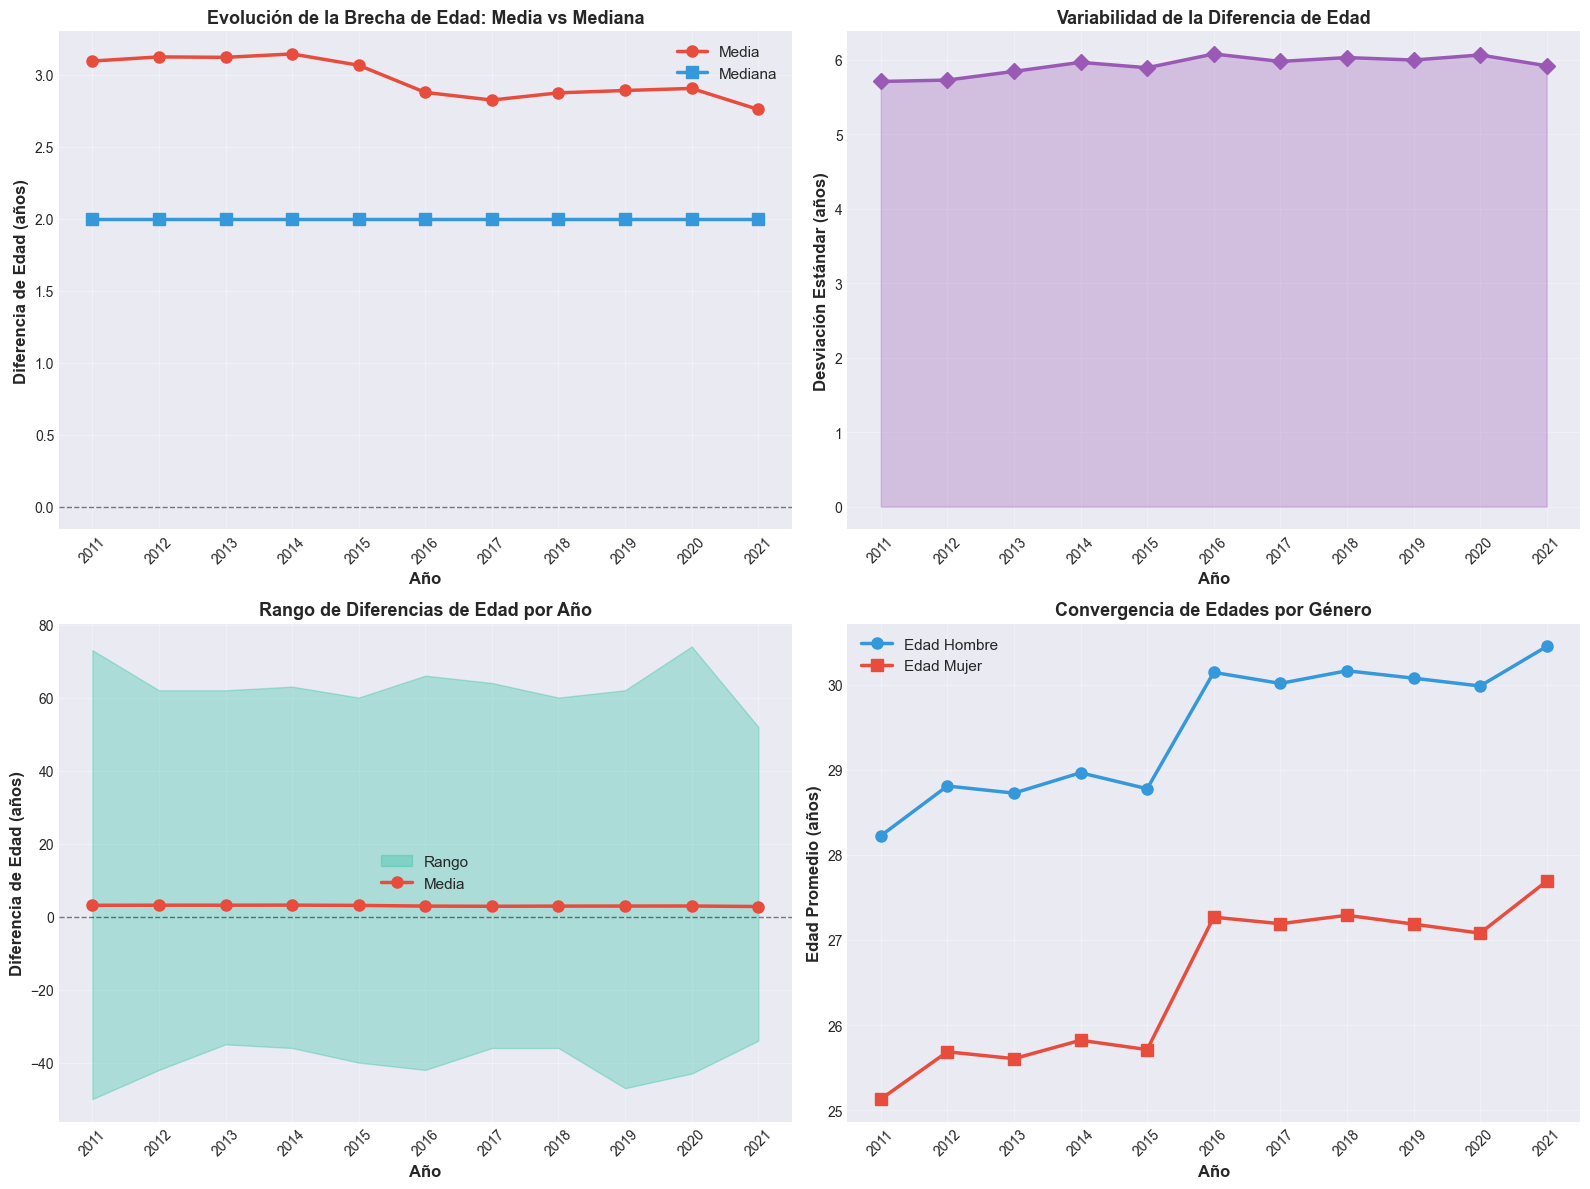

✓ Gráficos de tendencia generados


In [48]:
# Crear figura con múltiples subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 3.3.1 Evolución de diferencia media y mediana
ax1 = axes[0, 0]
ax1.plot(tendencia_anual['Año'], tendencia_anual['Dif_Media'], 
         marker='o', linewidth=2.5, markersize=8, color='#E74C3C', label='Media')
ax1.plot(tendencia_anual['Año'], tendencia_anual['Dif_Mediana'], 
         marker='s', linewidth=2.5, markersize=8, color='#3498DB', label='Mediana')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('Año', fontsize=12, fontweight='bold')
ax1.set_ylabel('Diferencia de Edad (años)', fontsize=12, fontweight='bold')
ax1.set_title('Evolución de la Brecha de Edad: Media vs Mediana', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(tendencia_anual['Año'])
ax1.tick_params(axis='x', rotation=45)

# 3.3.2 Variabilidad (desviación estándar)
ax2 = axes[0, 1]
ax2.plot(tendencia_anual['Año'], tendencia_anual['Dif_Std'], 
         marker='D', linewidth=2.5, markersize=8, color='#9B59B6')
ax2.fill_between(tendencia_anual['Año'], tendencia_anual['Dif_Std'], 
                 alpha=0.3, color='#9B59B6')
ax2.set_xlabel('Año', fontsize=12, fontweight='bold')
ax2.set_ylabel('Desviación Estándar (años)', fontsize=12, fontweight='bold')
ax2.set_title('Variabilidad de la Diferencia de Edad', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(tendencia_anual['Año'])
ax2.tick_params(axis='x', rotation=45)

# 3.3.3 Rango (Min y Max)
ax3 = axes[1, 0]
ax3.fill_between(tendencia_anual['Año'], tendencia_anual['Dif_Min'], tendencia_anual['Dif_Max'],
                 alpha=0.3, color='#1ABC9C', label='Rango')
ax3.plot(tendencia_anual['Año'], tendencia_anual['Dif_Media'], 
         marker='o', linewidth=2.5, markersize=8, color='#E74C3C', label='Media')
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax3.set_xlabel('Año', fontsize=12, fontweight='bold')
ax3.set_ylabel('Diferencia de Edad (años)', fontsize=12, fontweight='bold')
ax3.set_title('Rango de Diferencias de Edad por Año', fontsize=13, fontweight='bold')
ax3.legend(loc='best', fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.set_xticks(tendencia_anual['Año'])
ax3.tick_params(axis='x', rotation=45)

# 3.3.4 Edades absolutas por género
ax4 = axes[1, 1]
ax4.plot(tendencia_anual['Año'], tendencia_anual['Edad_Hombre'], 
         marker='o', linewidth=2.5, markersize=8, color='#3498DB', label='Edad Hombre')
ax4.plot(tendencia_anual['Año'], tendencia_anual['Edad_Mujer'], 
         marker='s', linewidth=2.5, markersize=8, color='#E74C3C', label='Edad Mujer')
ax4.set_xlabel('Año', fontsize=12, fontweight='bold')
ax4.set_ylabel('Edad Promedio (años)', fontsize=12, fontweight='bold')
ax4.set_title('Convergencia de Edades por Género', fontsize=13, fontweight='bold')
ax4.legend(loc='best', fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.set_xticks(tendencia_anual['Año'])
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("✓ Gráficos de tendencia generados")

## 4. Regresión Lineal: Modelando la Tendencia

Ajustamos un modelo de regresión lineal para cuantificar la tasa de cambio en la brecha de edad.

### 4.1 Modelo de Regresión

In [49]:
# Preparar datos para regresión
X = tendencia_anual[['Año']].values
y_media = tendencia_anual['Dif_Media'].values
y_mediana = tendencia_anual['Dif_Mediana'].values

# Crear modelos de regresión
modelo_media = LinearRegression()
modelo_mediana = LinearRegression()

# Entrenar modelos
modelo_media.fit(X, y_media)
modelo_mediana.fit(X, y_mediana)

# Predicciones
pred_media = modelo_media.predict(X)
pred_mediana = modelo_mediana.predict(X)

# Métricas de ajuste
r2_media = r2_score(y_media, pred_media)
r2_mediana = r2_score(y_mediana, pred_mediana)
rmse_media = np.sqrt(mean_squared_error(y_media, pred_media))
rmse_mediana = np.sqrt(mean_squared_error(y_mediana, pred_mediana))

print("📈 RESULTADOS DE REGRESIÓN LINEAL")
print("="*80)

print("\n🔴 DIFERENCIA MEDIA:")
print(f"  Ecuación: Diferencia = {modelo_media.intercept_:.4f} + {modelo_media.coef_[0]:.4f} × Año")
print(f"  R² (ajuste): {r2_media:.4f}")
print(f"  RMSE: {rmse_media:.4f} años")
print(f"  Pendiente: {modelo_media.coef_[0]:.4f} años/año")
if modelo_media.coef_[0] < 0:
    print(f"  → La brecha de edad DISMINUYE {abs(modelo_media.coef_[0]):.4f} años por cada año")
elif modelo_media.coef_[0] > 0:
    print(f"  → La brecha de edad AUMENTA {modelo_media.coef_[0]:.4f} años por cada año")
else:
    print(f"  → La brecha de edad se mantiene ESTABLE")

print("\n🔵 DIFERENCIA MEDIANA:")
print(f"  Ecuación: Diferencia = {modelo_mediana.intercept_:.4f} + {modelo_mediana.coef_[0]:.4f} × Año")
print(f"  R² (ajuste): {r2_mediana:.4f}")
print(f"  RMSE: {rmse_mediana:.4f} años")
print(f"  Pendiente: {modelo_mediana.coef_[0]:.4f} años/año")
if modelo_mediana.coef_[0] < 0:
    print(f"  → La brecha de edad DISMINUYE {abs(modelo_mediana.coef_[0]):.4f} años por cada año")
elif modelo_mediana.coef_[0] > 0:
    print(f"  → La brecha de edad AUMENTA {modelo_mediana.coef_[0]:.4f} años por cada año")
else:
    print(f"  → La brecha de edad se mantiene ESTABLE")

📈 RESULTADOS DE REGRESIÓN LINEAL

🔴 DIFERENCIA MEDIA:
  Ecuación: Diferencia = 76.8490 + -0.0366 × Año
  R² (ajuste): 0.7537
  RMSE: 0.0662 años
  Pendiente: -0.0366 años/año
  → La brecha de edad DISMINUYE 0.0366 años por cada año

🔵 DIFERENCIA MEDIANA:
  Ecuación: Diferencia = 2.0000 + 0.0000 × Año
  R² (ajuste): 1.0000
  RMSE: 0.0000 años
  Pendiente: 0.0000 años/año
  → La brecha de edad se mantiene ESTABLE


### 4.2 Cambio Total Estimado

In [50]:
# Análisis del cambio total
n_años = año_final - año_inicial
cambio_total_media = modelo_media.coef_[0] * n_años
cambio_total_mediana = modelo_mediana.coef_[0] * n_años

print("\n📊 CAMBIO TOTAL ESTIMADO POR REGRESIÓN")
print("="*80)
print(f"\nPeríodo analizado: {año_inicial}-{año_final} ({n_años} años)")
print(f"\nCambio total estimado:")
print(f"  Media: {cambio_total_media:+.2f} años")
print(f"  Mediana: {cambio_total_mediana:+.2f} años")

# Proyección a futuro
años_futuros = [2025, 2030]
print(f"\n🔮 PROYECCIÓN A FUTURO:")
for año in años_futuros:
    pred = modelo_media.predict([[año]])[0]
    print(f"  {año}: {pred:.2f} años (si la tendencia continúa)")


📊 CAMBIO TOTAL ESTIMADO POR REGRESIÓN

Período analizado: 2011.0-2021.0 (10.0 años)

Cambio total estimado:
  Media: -0.37 años
  Mediana: +0.00 años

🔮 PROYECCIÓN A FUTURO:
  2025: 2.64 años (si la tendencia continúa)
  2030: 2.46 años (si la tendencia continúa)


### 4.3 Visualización de Regresión

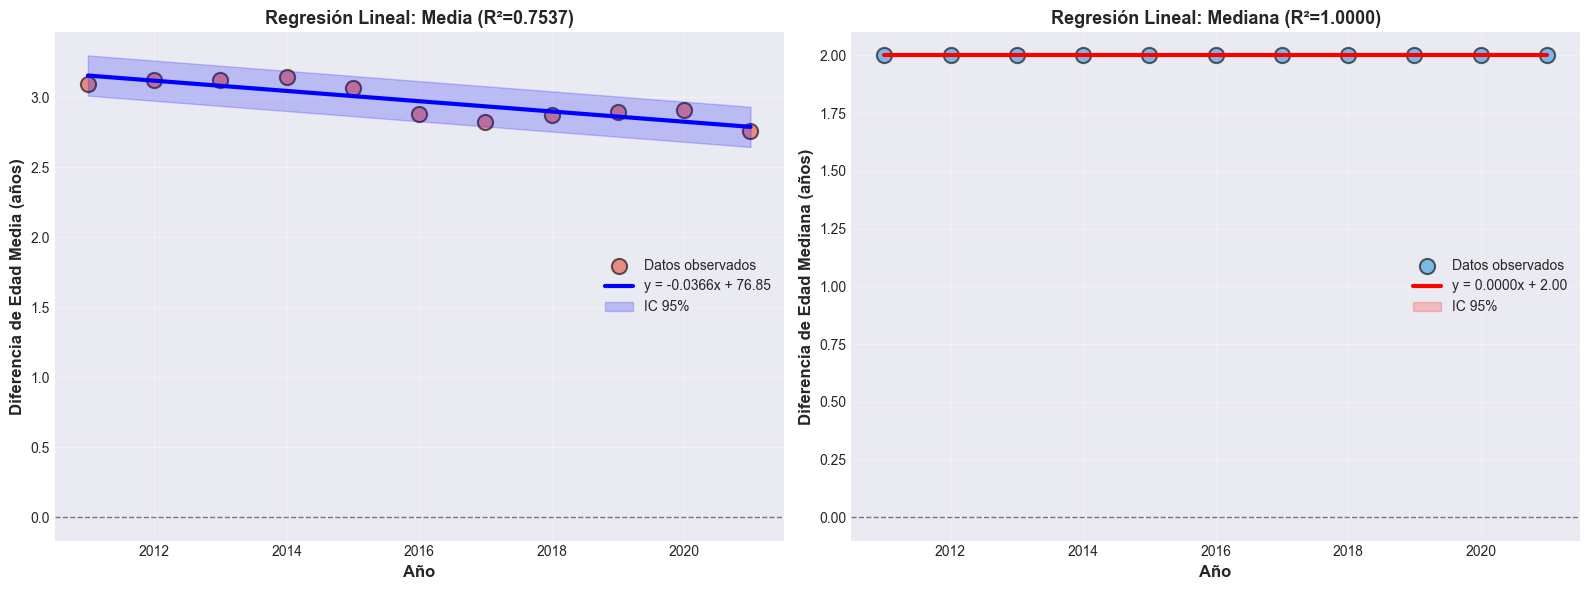

✓ Gráficos de regresión generados


In [51]:
# Visualización de las regresiones
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 4.3.1 Regresión de Media
ax1 = axes[0]
ax1.scatter(X, y_media, s=120, alpha=0.6, color='#E74C3C', edgecolors='black', linewidth=1.5, label='Datos observados')
ax1.plot(X, pred_media, 'b-', linewidth=3, label=f'y = {modelo_media.coef_[0]:.4f}x + {modelo_media.intercept_:.2f}')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Intervalo de confianza (simplificado)
residuos = y_media - pred_media
std_error = np.sqrt(np.sum(residuos**2) / (len(X) - 2))
ax1.fill_between(X.flatten(), pred_media - 1.96*std_error, pred_media + 1.96*std_error, 
                 alpha=0.2, color='blue', label='IC 95%')

ax1.set_xlabel('Año', fontsize=12, fontweight='bold')
ax1.set_ylabel('Diferencia de Edad Media (años)', fontsize=12, fontweight='bold')
ax1.set_title(f'Regresión Lineal: Media (R²={r2_media:.4f})', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# 4.3.2 Regresión de Mediana
ax2 = axes[1]
ax2.scatter(X, y_mediana, s=120, alpha=0.6, color='#3498DB', edgecolors='black', linewidth=1.5, label='Datos observados')
ax2.plot(X, pred_mediana, 'r-', linewidth=3, label=f'y = {modelo_mediana.coef_[0]:.4f}x + {modelo_mediana.intercept_:.2f}')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Intervalo de confianza
residuos = y_mediana - pred_mediana
std_error = np.sqrt(np.sum(residuos**2) / (len(X) - 2))
ax2.fill_between(X.flatten(), pred_mediana - 1.96*std_error, pred_mediana + 1.96*std_error, 
                 alpha=0.2, color='red', label='IC 95%')

ax2.set_xlabel('Año', fontsize=12, fontweight='bold')
ax2.set_ylabel('Diferencia de Edad Mediana (años)', fontsize=12, fontweight='bold')
ax2.set_title(f'Regresión Lineal: Mediana (R²={r2_mediana:.4f})', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Gráficos de regresión generados")

## 5. Comparación Estadística 2011 vs 2021

Realizamos pruebas de hipótesis para comparar las distribuciones de diferencia de edad.

In [52]:
# Extraer datos de años específicos
datos_2011 = mat_clean[mat_clean['AÑOREG'] == año_inicial]
datos_2021 = mat_clean[mat_clean['AÑOREG'] == año_final]

print(f"\n📊 COMPARACIÓN {año_inicial} vs {año_final}")
print("="*80)
print(f"\nRegistros {año_inicial}: {len(datos_2011):,}")
print(f"Registros {año_final}: {len(datos_2021):,}")


📊 COMPARACIÓN 2011.0 vs 2021.0

Registros 2011.0: 69,825
Registros 2021.0: 7,521


### 5.1 Estadísticas Descriptivas Comparativas

In [53]:
print(f"\n📈 ESTADÍSTICAS DESCRIPTIVAS")
print("="*80)

stats_2011 = {
    'Media': datos_2011['DIFERENCIA_EDAD'].mean(),
    'Mediana': datos_2011['DIFERENCIA_EDAD'].median(),
    'Moda': datos_2011['DIFERENCIA_EDAD'].mode()[0] if len(datos_2011['DIFERENCIA_EDAD'].mode()) > 0 else None,
    'Desv. Std': datos_2011['DIFERENCIA_EDAD'].std(),
    'Mín': datos_2011['DIFERENCIA_EDAD'].min(),
    'Máx': datos_2011['DIFERENCIA_EDAD'].max(),
    'Q1': datos_2011['DIFERENCIA_EDAD'].quantile(0.25),
    'Q3': datos_2011['DIFERENCIA_EDAD'].quantile(0.75)
}

stats_2021 = {
    'Media': datos_2021['DIFERENCIA_EDAD'].mean(),
    'Mediana': datos_2021['DIFERENCIA_EDAD'].median(),
    'Moda': datos_2021['DIFERENCIA_EDAD'].mode()[0] if len(datos_2021['DIFERENCIA_EDAD'].mode()) > 0 else None,
    'Desv. Std': datos_2021['DIFERENCIA_EDAD'].std(),
    'Mín': datos_2021['DIFERENCIA_EDAD'].min(),
    'Máx': datos_2021['DIFERENCIA_EDAD'].max(),
    'Q1': datos_2021['DIFERENCIA_EDAD'].quantile(0.25),
    'Q3': datos_2021['DIFERENCIA_EDAD'].quantile(0.75)
}

# Crear DataFrame de manera más explícita para evitar el error
df_stats = pd.DataFrame({
    año_inicial: list(stats_2011.values()),
    año_final: list(stats_2021.values())
}, index=list(stats_2011.keys()))

# Calcular columna de cambio por separado
cambio_values = []
for k in stats_2011.keys():
    if k != 'Moda':
        cambio_values.append(stats_2021[k] - stats_2011[k])
    else:
        cambio_values.append(None)

df_stats['Cambio'] = cambio_values

print(df_stats.to_string())


📈 ESTADÍSTICAS DESCRIPTIVAS
              2011.0     2021.0     Cambio
Media       3.096155   2.759872  -0.336282
Mediana     2.000000   2.000000   0.000000
Moda        2.000000   1.000000        NaN
Desv. Std   5.705584   5.916016   0.210432
Mín       -50.000000 -34.000000  16.000000
Máx        73.000000  52.000000 -21.000000
Q1          0.000000   0.000000   0.000000
Q3          5.000000   5.000000   0.000000


### 5.2 Tests Estadísticos

In [54]:
# Test de Mann-Whitney U (no paramétrico)
stat_mw, p_mw = mannwhitneyu(datos_2011['DIFERENCIA_EDAD'], datos_2021['DIFERENCIA_EDAD'], alternative='two-sided')

print("\n🔵 TEST DE MANN-WHITNEY U (no paramétrico):")
print("="*80)
print(f"  Estadístico U: {stat_mw:.2f}")
print(f"  p-value: {p_mw:.6f}")
if p_mw < 0.05:
    print(f"  ✓ Las distribuciones son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)")
    med_diff = datos_2021['DIFERENCIA_EDAD'].median() - datos_2011['DIFERENCIA_EDAD'].median()
    print(f"  Diferencia de medianas: {med_diff:+.2f} años")
else:
    print(f"  ✗ No hay diferencia significativa entre las distribuciones")

# Test t de Student (paramétrico)
stat_t, p_t = ttest_ind(datos_2011['DIFERENCIA_EDAD'], datos_2021['DIFERENCIA_EDAD'])

print("\n🔴 TEST T DE STUDENT (paramétrico):")
print("="*80)
print(f"  Estadístico t: {stat_t:.4f}")
print(f"  p-value: {p_t:.6f}")
if p_t < 0.05:
    print(f"  ✓ Las medias son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)")
    mean_diff = datos_2021['DIFERENCIA_EDAD'].mean() - datos_2011['DIFERENCIA_EDAD'].mean()
    print(f"  Diferencia de medias: {mean_diff:+.2f} años")
    
    # Tamaño del efecto (Cohen's d)
    pooled_std = np.sqrt(((len(datos_2011)-1)*datos_2011['DIFERENCIA_EDAD'].std()**2 + 
                          (len(datos_2021)-1)*datos_2021['DIFERENCIA_EDAD'].std()**2) / 
                         (len(datos_2011) + len(datos_2021) - 2))
    cohens_d = mean_diff / pooled_std
    print(f"  Cohen's d: {cohens_d:.4f}", end=" ")
    if abs(cohens_d) < 0.2:
        print("(efecto pequeño)")
    elif abs(cohens_d) < 0.5:
        print("(efecto pequeño-moderado)")
    elif abs(cohens_d) < 0.8:
        print("(efecto moderado-grande)")
    else:
        print("(efecto grande)")
else:
    print(f"  ✗ No hay diferencia significativa entre las medias")


🔵 TEST DE MANN-WHITNEY U (no paramétrico):
  Estadístico U: 275538395.50
  p-value: 0.000000
  ✓ Las distribuciones son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)
  Diferencia de medianas: +0.00 años

🔴 TEST T DE STUDENT (paramétrico):
  Estadístico t: 4.8389
  p-value: 0.000001
  ✓ Las medias son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)
  Diferencia de medias: -0.34 años
  Cohen's d: -0.0587 (efecto pequeño)


### 5.3 Análisis de Categorías

In [55]:
# Comparar categorías de diferencia
def categorizar_diferencia(df):
    return pd.DataFrame({
        'Mujer mayor (< 0)': [(df['DIFERENCIA_EDAD'] < 0).sum(), (df['DIFERENCIA_EDAD'] < 0).mean()*100],
        'Misma edad (0)': [(df['DIFERENCIA_EDAD'] == 0).sum(), (df['DIFERENCIA_EDAD'] == 0).mean()*100],
        'Hombre mayor 1-3 años': [((df['DIFERENCIA_EDAD'] > 0) & (df['DIFERENCIA_EDAD'] <= 3)).sum(), 
                                   ((df['DIFERENCIA_EDAD'] > 0) & (df['DIFERENCIA_EDAD'] <= 3)).mean()*100],
        'Hombre mayor 4-6 años': [((df['DIFERENCIA_EDAD'] > 3) & (df['DIFERENCIA_EDAD'] <= 6)).sum(), 
                                   ((df['DIFERENCIA_EDAD'] > 3) & (df['DIFERENCIA_EDAD'] <= 6)).mean()*100],
        'Hombre mayor 7-10 años': [((df['DIFERENCIA_EDAD'] > 6) & (df['DIFERENCIA_EDAD'] <= 10)).sum(), 
                                    ((df['DIFERENCIA_EDAD'] > 6) & (df['DIFERENCIA_EDAD'] <= 10)).mean()*100],
        'Hombre mayor >10 años': [(df['DIFERENCIA_EDAD'] > 10).sum(), (df['DIFERENCIA_EDAD'] > 10).mean()*100]
    }, index=['N', '%']).T

print(f"\n📊 DISTRIBUCIÓN POR CATEGORÍAS")
print("="*80)
print(f"\n{año_inicial}:")
print(categorizar_diferencia(datos_2011).to_string())
print(f"\n{año_final}:")
print(categorizar_diferencia(datos_2021).to_string())


📊 DISTRIBUCIÓN POR CATEGORÍAS

2011.0:
                              N          %
Mujer mayor (< 0)       14546.0  20.832080
Misma edad (0)           6036.0   8.644468
Hombre mayor 1-3 años   21267.0  30.457573
Hombre mayor 4-6 años   14421.0  20.653061
Hombre mayor 7-10 años   8064.0  11.548872
Hombre mayor >10 años    5491.0   7.863946

2021.0:
                             N          %
Mujer mayor (< 0)       1794.0  23.853211
Misma edad (0)           723.0   9.613083
Hombre mayor 1-3 años   2268.0  30.155564
Hombre mayor 4-6 años   1378.0  18.322032
Hombre mayor 7-10 años   767.0  10.198112
Hombre mayor >10 años    591.0   7.857998


### 5.4 Visualización de Comparación

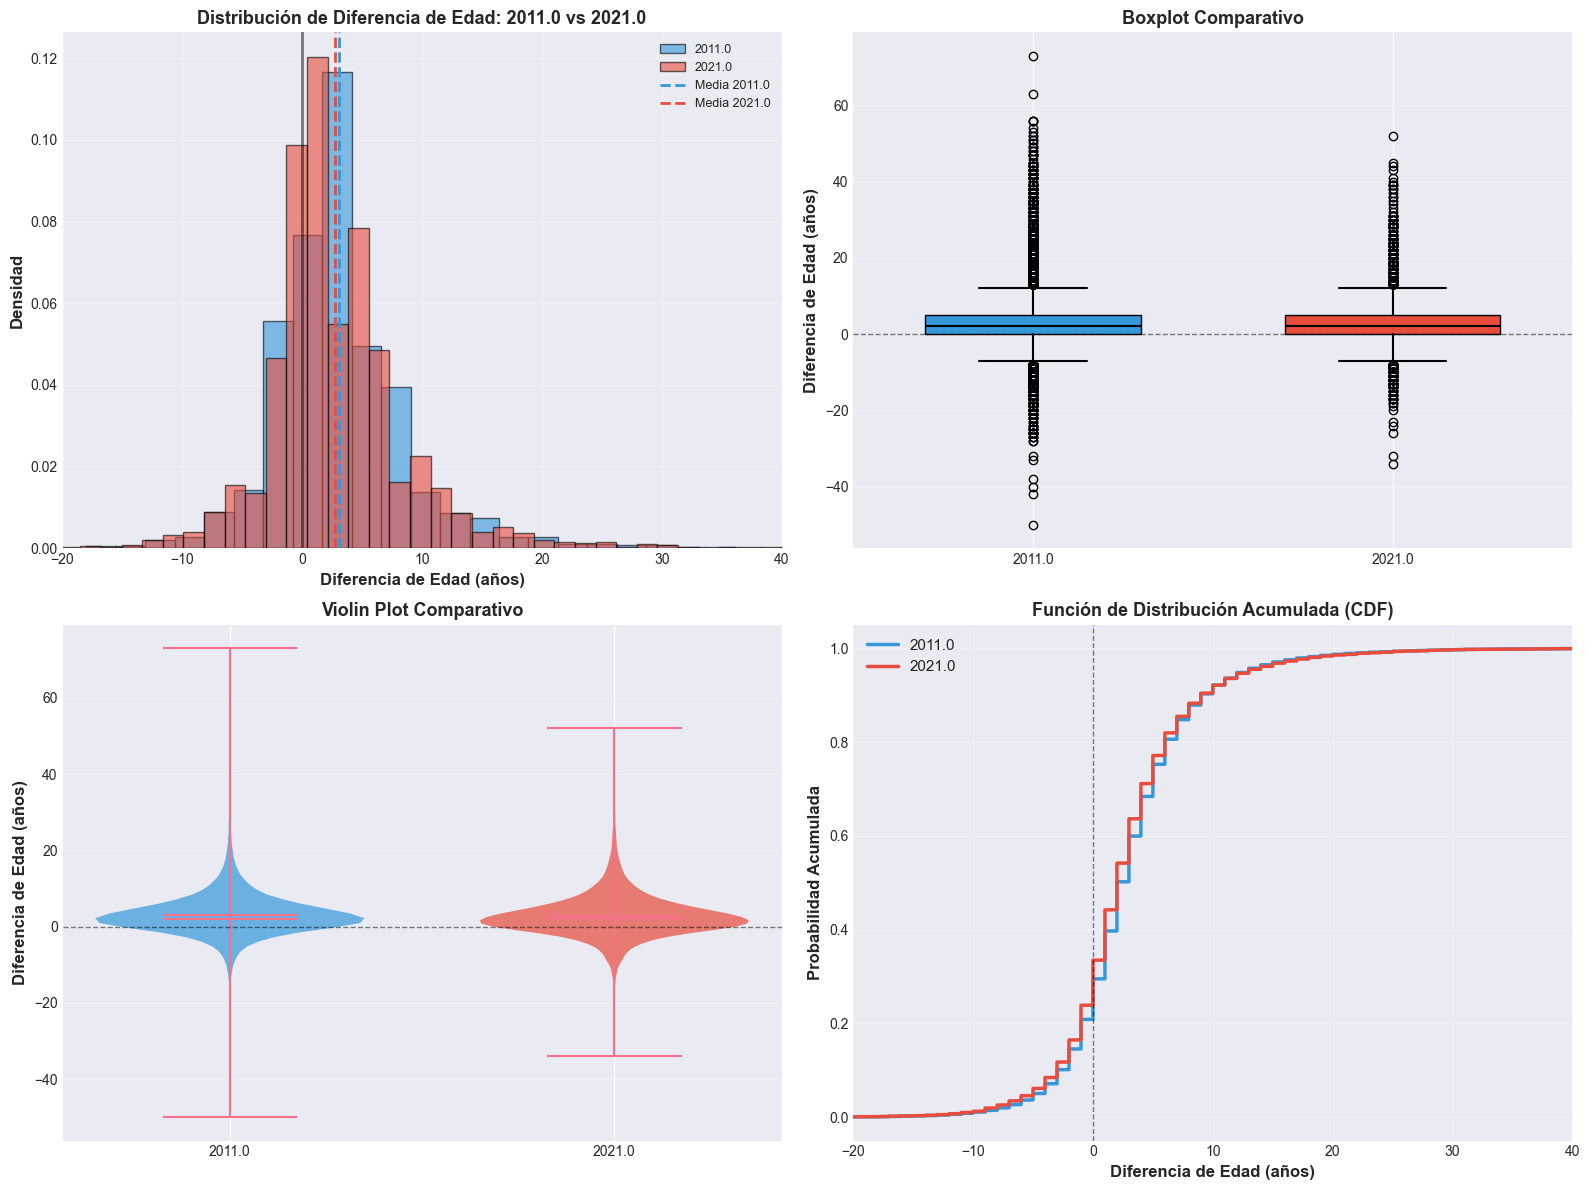

✓ Gráficos de comparación generados


In [56]:
# Visualización de distribuciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 5.4.1 Histogramas superpuestos
ax1 = axes[0, 0]
ax1.hist(datos_2011['DIFERENCIA_EDAD'], bins=50, alpha=0.6, color='#3498DB', 
         label=f'{año_inicial}', edgecolor='black', density=True)
ax1.hist(datos_2021['DIFERENCIA_EDAD'], bins=50, alpha=0.6, color='#E74C3C', 
         label=f'{año_final}', edgecolor='black', density=True)
ax1.axvline(datos_2011['DIFERENCIA_EDAD'].mean(), color='#3498DB', linestyle='--', linewidth=2, label=f'Media {año_inicial}')
ax1.axvline(datos_2021['DIFERENCIA_EDAD'].mean(), color='#E74C3C', linestyle='--', linewidth=2, label=f'Media {año_final}')
ax1.axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.5)
ax1.set_xlabel('Diferencia de Edad (años)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Densidad', fontsize=12, fontweight='bold')
ax1.set_title(f'Distribución de Diferencia de Edad: {año_inicial} vs {año_final}', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-20, 40)

# 5.4.2 Boxplots
ax2 = axes[0, 1]
bp = ax2.boxplot([datos_2011['DIFERENCIA_EDAD'], datos_2021['DIFERENCIA_EDAD']], 
                  labels=[f'{año_inicial}', f'{año_final}'],
                  patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('#3498DB')
bp['boxes'][1].set_facecolor('#E74C3C')
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='black', linewidth=1.5)
ax2.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_ylabel('Diferencia de Edad (años)', fontsize=12, fontweight='bold')
ax2.set_title('Boxplot Comparativo', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 5.4.3 Violin plots
ax3 = axes[1, 0]
parts = ax3.violinplot([datos_2011['DIFERENCIA_EDAD'], datos_2021['DIFERENCIA_EDAD']], 
                       positions=[1, 2], widths=0.7, showmeans=True, showmedians=True)
colors = ['#3498DB', '#E74C3C']
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
ax3.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax3.set_xticks([1, 2])
ax3.set_xticklabels([f'{año_inicial}', f'{año_final}'])
ax3.set_ylabel('Diferencia de Edad (años)', fontsize=12, fontweight='bold')
ax3.set_title('Violin Plot Comparativo', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 5.4.4 Distribuciones acumuladas (CDF)
ax4 = axes[1, 1]
sorted_2011 = np.sort(datos_2011['DIFERENCIA_EDAD'])
sorted_2021 = np.sort(datos_2021['DIFERENCIA_EDAD'])
cdf_2011 = np.arange(1, len(sorted_2011) + 1) / len(sorted_2011)
cdf_2021 = np.arange(1, len(sorted_2021) + 1) / len(sorted_2021)

ax4.plot(sorted_2011, cdf_2011, linewidth=2.5, color='#3498DB', label=f'{año_inicial}')
ax4.plot(sorted_2021, cdf_2021, linewidth=2.5, color='#E74C3C', label=f'{año_final}')
ax4.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_xlabel('Diferencia de Edad (años)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Probabilidad Acumulada', fontsize=12, fontweight='bold')
ax4.set_title('Función de Distribución Acumulada (CDF)', fontsize=13, fontweight='bold')
ax4.legend(loc='best', fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.set_xlim(-20, 40)

plt.tight_layout()
plt.show()

print("✓ Gráficos de comparación generados")

## 6. Clustering: Patrones de Emparejamiento

Agrupamos las parejas según características de edad para identificar patrones de emparejamiento.

### 6.1 Preparación de Datos para Clustering

In [57]:
# Preparar features para clustering
# Usaremos: edad hombre, edad mujer, diferencia de edad, edad promedio
features_clustering = mat_clean[[
    'EDADHOM', 'EDADMUJ', 'DIFERENCIA_EDAD', 'EDAD_PROMEDIO'
]].values

# Normalizar
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_clustering)

print("📊 Datos preparados para clustering:")
print(f"   - Dimensiones: {features_scaled.shape}")
print(f"   - Features: Edad_Hombre, Edad_Mujer, Diferencia_Edad, Edad_Promedio")

📊 Datos preparados para clustering:
   - Dimensiones: (751419, 4)
   - Features: Edad_Hombre, Edad_Mujer, Diferencia_Edad, Edad_Promedio


### 6.2 Determinación del Número Óptimo de Clusters

In [58]:
# Usar una muestra para acelerar el proceso
sample_size = min(10000, len(features_scaled))
np.random.seed(42)
sample_indices = np.random.choice(len(features_scaled), sample_size, replace=False)
features_sample = features_scaled[sample_indices]

print(f"ℹ️ Usando muestra de {sample_size:,} registros para clustering")

# Método del codo y silhouette
inertias = []
silhouette_scores = []
K_range = range(2, 8)

print("\n🔍 Evaluando diferentes números de clusters...")
print("="*80)
print(f"{'K':<5} {'Inercia':<15} {'Silhouette':<15} {'Interpretación'}")
print("="*80)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_sample)
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(features_sample, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    if silhouette_avg > 0.5:
        interpretacion = "Buena"
    elif silhouette_avg > 0.3:
        interpretacion = "Aceptable"
    else:
        interpretacion = "Pobre"
    
    print(f"{k:<5} {kmeans.inertia_:<15.2f} {silhouette_avg:<15.4f} {interpretacion}")

# Determinar mejor K
best_k = K_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

print("\n" + "="*80)
print(f"✓ MEJOR NÚMERO DE CLUSTERS: K = {best_k}")
print(f"  Silhouette Score: {best_silhouette:.4f}")
print("="*80)

ℹ️ Usando muestra de 10,000 registros para clustering

🔍 Evaluando diferentes números de clusters...
K     Inercia         Silhouette      Interpretación
2     19923.89        0.6270          Buena
3     15229.33        0.4249          Aceptable
4     11815.80        0.4196          Aceptable
5     9773.73         0.3769          Aceptable
6     8171.49         0.3735          Aceptable
7     7276.84         0.3786          Aceptable

✓ MEJOR NÚMERO DE CLUSTERS: K = 2
  Silhouette Score: 0.6270


### 6.3 Aplicar Clustering y Análisis

In [59]:
# Aplicar clustering con mejor K a muestra
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
mat_clean_sample = mat_clean.iloc[sample_indices].copy()
mat_clean_sample['Cluster'] = kmeans_final.fit_predict(features_sample)

print(f"✓ Clustering completado con {best_k} clusters")
print(f"\nDistribución de parejas por cluster:")
print(mat_clean_sample['Cluster'].value_counts().sort_index())

✓ Clustering completado con 2 clusters

Distribución de parejas por cluster:
Cluster
0    8633
1    1367
Name: count, dtype: int64


### 6.4 Interpretación de Clusters

In [60]:
# Análisis de clusters
print("\n📊 CARACTERÍSTICAS DE LOS CLUSTERS")
print("="*80)

cluster_names = {}

for cluster_id in range(best_k):
    cluster_data = mat_clean_sample[mat_clean_sample['Cluster'] == cluster_id]
    
    edad_h_media = cluster_data['EDADHOM'].mean()
    edad_m_media = cluster_data['EDADMUJ'].mean()
    dif_media = cluster_data['DIFERENCIA_EDAD'].mean()
    edad_prom = cluster_data['EDAD_PROMEDIO'].mean()
    
    # Asignar nombre descriptivo
    if edad_prom < 25:
        edad_cat = "Jóvenes"
    elif edad_prom < 35:
        edad_cat = "Adultos jóvenes"
    elif edad_prom < 45:
        edad_cat = "Adultos"
    else:
        edad_cat = "Adultos mayores"
    
    if abs(dif_media) < 2:
        dif_cat = "edades similares"
    elif dif_media < 5:
        dif_cat = "hombre ligeramente mayor"
    elif dif_media < 10:
        dif_cat = "hombre mayor"
    else:
        dif_cat = "hombre mucho mayor"
    
    nombre = f"{edad_cat}, {dif_cat}"
    cluster_names[cluster_id] = nombre
    
    print(f"\n🔷 CLUSTER {cluster_id}: {nombre.upper()}")
    print("="*80)
    print(f"N parejas: {len(cluster_data):,} ({len(cluster_data)/len(mat_clean_sample)*100:.1f}%)")
    print(f"\nCaracterísticas:")
    print(f"  Edad Hombre (media): {edad_h_media:.1f} años")
    print(f"  Edad Mujer (media): {edad_m_media:.1f} años")
    print(f"  Diferencia (media): {dif_media:+.1f} años")
    print(f"  Edad Promedio pareja: {edad_prom:.1f} años")
    print(f"\nDistribución de diferencias:")
    print(f"  Mujer mayor: {(cluster_data['DIFERENCIA_EDAD'] < 0).sum()} ({(cluster_data['DIFERENCIA_EDAD'] < 0).mean()*100:.1f}%)")
    print(f"  Misma edad: {(cluster_data['DIFERENCIA_EDAD'] == 0).sum()} ({(cluster_data['DIFERENCIA_EDAD'] == 0).mean()*100:.1f}%)")
    print(f"  Hombre mayor: {(cluster_data['DIFERENCIA_EDAD'] > 0).sum()} ({(cluster_data['DIFERENCIA_EDAD'] > 0).mean()*100:.1f}%)")


📊 CARACTERÍSTICAS DE LOS CLUSTERS

🔷 CLUSTER 0: JÓVENES, HOMBRE LIGERAMENTE MAYOR
N parejas: 8,633 (86.3%)

Características:
  Edad Hombre (media): 25.6 años
  Edad Mujer (media): 23.4 años
  Diferencia (media): +2.3 años
  Edad Promedio pareja: 24.5 años

Distribución de diferencias:
  Mujer mayor: 1959 (22.7%)
  Misma edad: 850 (9.8%)
  Hombre mayor: 5824 (67.5%)

🔷 CLUSTER 1: ADULTOS MAYORES, HOMBRE MAYOR
N parejas: 1,367 (13.7%)

Características:
  Edad Hombre (media): 52.7 años
  Edad Mujer (media): 45.2 años
  Diferencia (media): +7.4 años
  Edad Promedio pareja: 48.9 años

Distribución de diferencias:
  Mujer mayor: 210 (15.4%)
  Misma edad: 68 (5.0%)
  Hombre mayor: 1089 (79.7%)


### 6.5 Visualización de Clusters

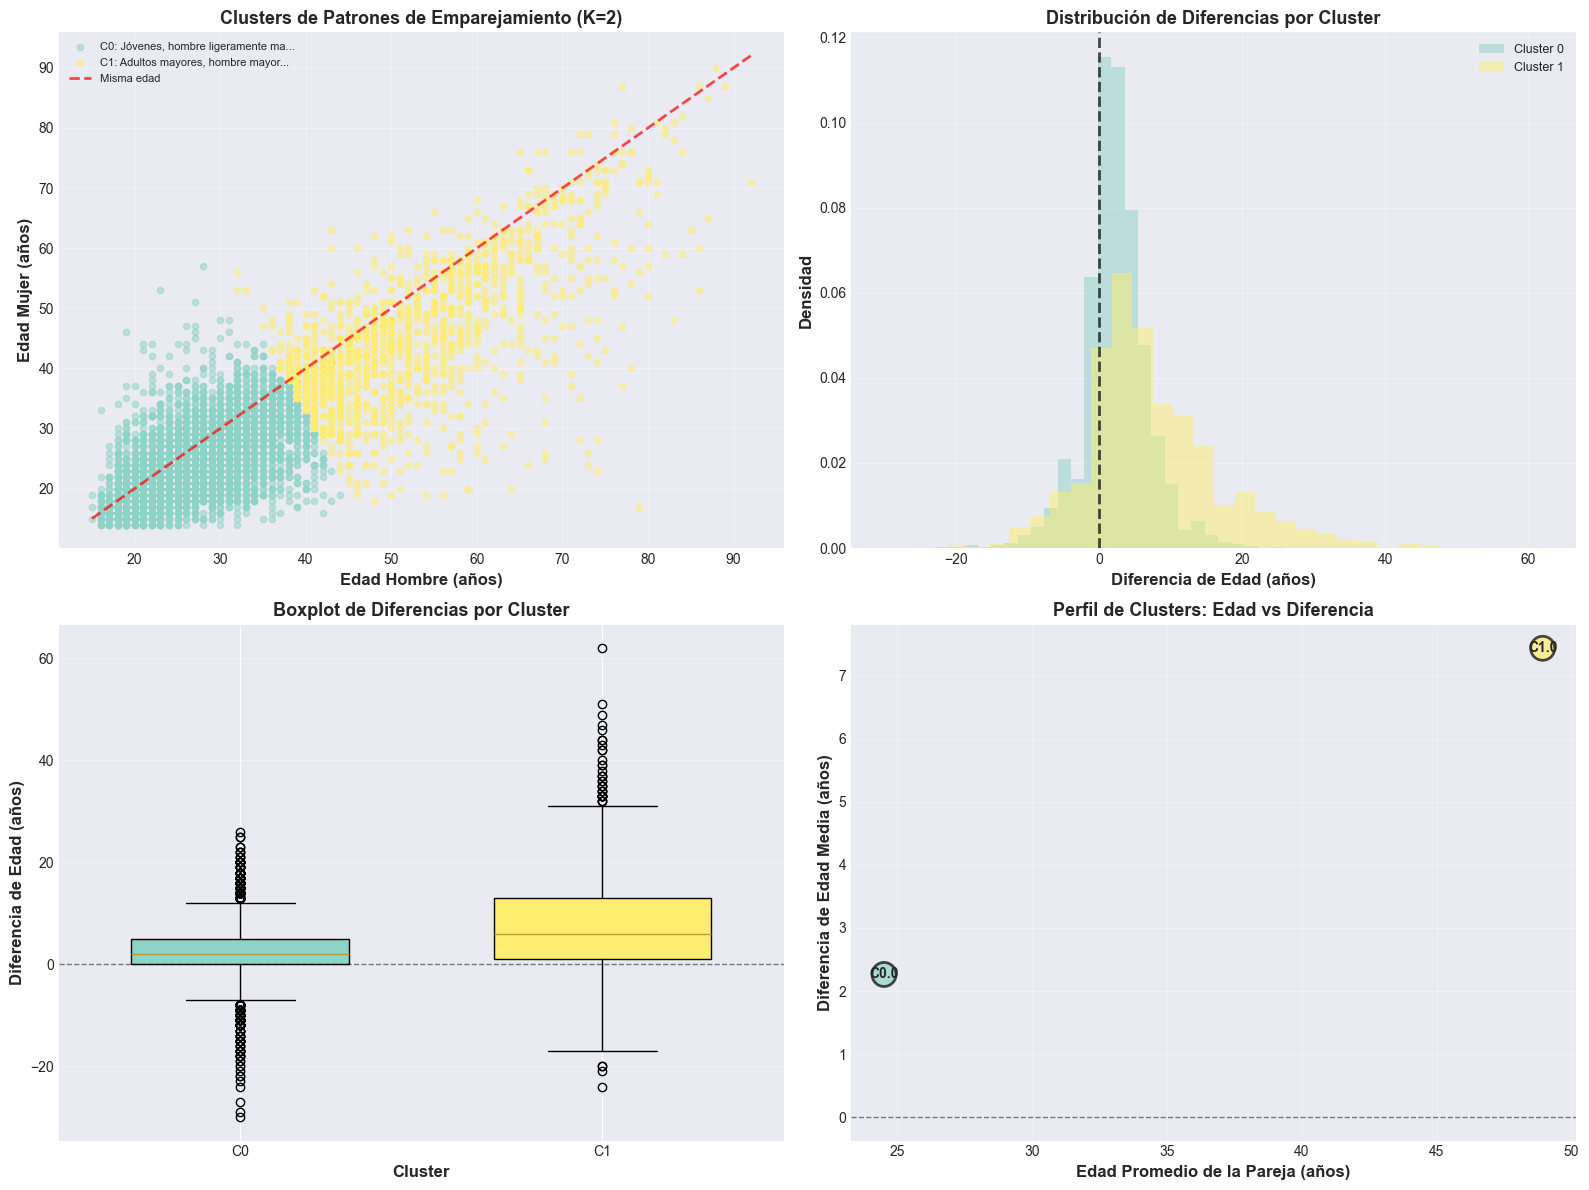

✓ Visualizaciones de clustering generadas


In [61]:
# Visualización de clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors = plt.cm.Set3(np.linspace(0, 1, best_k))

# 6.5.1 Scatter: Edad Hombre vs Mujer
ax1 = axes[0, 0]
for cluster_id in range(best_k):
    cluster_data = mat_clean_sample[mat_clean_sample['Cluster'] == cluster_id]
    ax1.scatter(cluster_data['EDADHOM'], cluster_data['EDADMUJ'],
               s=20, alpha=0.5, color=colors[cluster_id], 
               label=f'C{cluster_id}: {cluster_names[cluster_id][:30]}...')

# Línea de igualdad
lims = [15, max(mat_clean_sample['EDADHOM'].max(), mat_clean_sample['EDADMUJ'].max())]
ax1.plot(lims, lims, 'r--', linewidth=2, alpha=0.7, label='Misma edad')

ax1.set_xlabel('Edad Hombre (años)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Edad Mujer (años)', fontsize=12, fontweight='bold')
ax1.set_title(f'Clusters de Patrones de Emparejamiento (K={best_k})', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=8)
ax1.grid(True, alpha=0.3)

# 6.5.2 Histograma de diferencias por cluster
ax2 = axes[0, 1]
for cluster_id in range(best_k):
    cluster_data = mat_clean_sample[mat_clean_sample['Cluster'] == cluster_id]
    ax2.hist(cluster_data['DIFERENCIA_EDAD'], bins=30, alpha=0.5, 
            color=colors[cluster_id], label=f'Cluster {cluster_id}', density=True)

ax2.axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_xlabel('Diferencia de Edad (años)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Densidad', fontsize=12, fontweight='bold')
ax2.set_title('Distribución de Diferencias por Cluster', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

# 6.5.3 Boxplot de diferencias por cluster
ax3 = axes[1, 0]
data_boxplot = [mat_clean_sample[mat_clean_sample['Cluster'] == i]['DIFERENCIA_EDAD'] 
                for i in range(best_k)]
bp = ax3.boxplot(data_boxplot, labels=[f'C{i}' for i in range(best_k)],
                patch_artist=True, widths=0.6)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax3.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax3.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax3.set_ylabel('Diferencia de Edad (años)', fontsize=12, fontweight='bold')
ax3.set_title('Boxplot de Diferencias por Cluster', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 6.5.4 Distribución de edades promedio por cluster
ax4 = axes[1, 1]
cluster_stats = mat_clean_sample.groupby('Cluster').agg({
    'EDAD_PROMEDIO': 'mean',
    'DIFERENCIA_EDAD': 'mean'
}).reset_index()

ax4.scatter(cluster_stats['EDAD_PROMEDIO'], cluster_stats['DIFERENCIA_EDAD'],
           s=300, alpha=0.7, c=colors[:best_k], edgecolors='black', linewidth=2)
for i, row in cluster_stats.iterrows():
    ax4.annotate(f'C{row["Cluster"]}', 
                (row['EDAD_PROMEDIO'], row['DIFERENCIA_EDAD']),
                fontsize=10, ha='center', va='center', fontweight='bold')

ax4.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_xlabel('Edad Promedio de la Pareja (años)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Diferencia de Edad Media (años)', fontsize=12, fontweight='bold')
ax4.set_title('Perfil de Clusters: Edad vs Diferencia', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizaciones de clustering generadas")

## 7. Validación de Hipótesis

Evaluamos la hipótesis usando múltiples criterios.

In [62]:
print("🔬 HIPÓTESIS PLANTEADA:")
print("="*80)
print("'La diferencia de edad entre cónyuges se ha reducido con el tiempo,")
print(" reflejando mayor equidad de género y cambios en patrones de emparejamiento,")
print(" con parejas más cercanas en edad que hace una década'")
print("\n📊 EVIDENCIA ENCONTRADA:")
print("="*80)

🔬 HIPÓTESIS PLANTEADA:
'La diferencia de edad entre cónyuges se ha reducido con el tiempo,
 reflejando mayor equidad de género y cambios en patrones de emparejamiento,
 con parejas más cercanas en edad que hace una década'

📊 EVIDENCIA ENCONTRADA:


### 7.1 Criterio 1: Pendiente Negativa en Regresión

In [63]:
print("\n1. REGRESIÓN LINEAL - TENDENCIA DE REDUCCIÓN:")
print("-" * 80)

if modelo_media.coef_[0] < 0 and r2_media > 0.4:
    print(f"  ✓ Media: Pendiente negativa ({modelo_media.coef_[0]:.4f}) con ajuste aceptable (R²={r2_media:.4f})")
    print(f"     La brecha se reduce {abs(modelo_media.coef_[0]):.4f} años por año")
    validacion_1a = True
else:
    print(f"  ✗ Media: Pendiente={modelo_media.coef_[0]:.4f}, R²={r2_media:.4f}")
    print(f"     No se observa reducción clara")
    validacion_1a = False

if modelo_mediana.coef_[0] < 0 and r2_mediana > 0.4:
    print(f"  ✓ Mediana: Pendiente negativa ({modelo_mediana.coef_[0]:.4f}) con ajuste aceptable (R²={r2_mediana:.4f})")
    print(f"     La brecha se reduce {abs(modelo_mediana.coef_[0]):.4f} años por año")
    validacion_1b = True
else:
    print(f"  ✗ Mediana: Pendiente={modelo_mediana.coef_[0]:.4f}, R²={r2_mediana:.4f}")
    print(f"     No se observa reducción clara")
    validacion_1b = False

validacion_1 = validacion_1a or validacion_1b


1. REGRESIÓN LINEAL - TENDENCIA DE REDUCCIÓN:
--------------------------------------------------------------------------------
  ✓ Media: Pendiente negativa (-0.0366) con ajuste aceptable (R²=0.7537)
     La brecha se reduce 0.0366 años por año
  ✗ Mediana: Pendiente=0.0000, R²=1.0000
     No se observa reducción clara


### 7.2 Criterio 2: Reducción Significativa 2011-2021

In [64]:
print("\n2. CAMBIO SIGNIFICATIVO 2011-2021:")
print("-" * 80)

# Verificar si hay reducción sustancial (más de 0.3 años) y significativa
if cambio_media < -0.3 and p_t < 0.05:
    print(f"  ✓ Reducción sustancial y significativa de {abs(cambio_media):.2f} años (p={p_t:.4f})")
    print(f"     Cambio porcentual: {cambio_media_pct:.2f}%")
    validacion_2 = True
elif cambio_media < 0 and p_t < 0.05:
    print(f"  ⚠️  Reducción significativa pero modesta de {abs(cambio_media):.2f} años (p={p_t:.4f})")
    validacion_2 = True
else:
    print(f"  ✗ Cambio de {cambio_media:.2f} años no es significativo o no es reducción")
    validacion_2 = False


2. CAMBIO SIGNIFICATIVO 2011-2021:
--------------------------------------------------------------------------------
  ✓ Reducción sustancial y significativa de 0.34 años (p=0.0000)
     Cambio porcentual: -10.86%


### 7.3 Criterio 3: Distribuciones Diferentes

In [65]:
print("\n3. CAMBIO EN DISTRIBUCIONES:")
print("-" * 80)

if p_mw < 0.05:
    print(f"  ✓ Las distribuciones 2011 vs 2021 son significativamente diferentes")
    print(f"     Test Mann-Whitney: p={p_mw:.6f}")
    validacion_3 = True
else:
    print(f"  ✗ No hay diferencia significativa en las distribuciones")
    print(f"     Test Mann-Whitney: p={p_mw:.6f}")
    validacion_3 = False


3. CAMBIO EN DISTRIBUCIONES:
--------------------------------------------------------------------------------
  ✓ Las distribuciones 2011 vs 2021 son significativamente diferentes
     Test Mann-Whitney: p=0.000000


### 7.4 Criterio 4: Mayor Proporción de Parejas Cercanas en Edad

In [66]:
print("\n4. CAMBIO EN PATRONES DE EMPAREJAMIENTO:")
print("-" * 80)

# Calcular proporción de parejas con diferencia <= 3 años
prop_cercanas_2011 = ((datos_2011['DIFERENCIA_EDAD'].abs() <= 3).sum() / len(datos_2011)) * 100
prop_cercanas_2021 = ((datos_2021['DIFERENCIA_EDAD'].abs() <= 3).sum() / len(datos_2021)) * 100
cambio_prop = prop_cercanas_2021 - prop_cercanas_2011

print(f"  Parejas con diferencia ≤3 años:")
print(f"    {año_inicial}: {prop_cercanas_2011:.2f}%")
print(f"    {año_final}: {prop_cercanas_2021:.2f}%")
print(f"    Cambio: {cambio_prop:+.2f} puntos porcentuales")

if cambio_prop > 1:
    print(f"\n  ✓ Mayor proporción de parejas cercanas en edad en {año_final}")
    validacion_4 = True
else:
    print(f"\n  ✗ No hay aumento significativo en parejas cercanas en edad")
    validacion_4 = False


4. CAMBIO EN PATRONES DE EMPAREJAMIENTO:
--------------------------------------------------------------------------------
  Parejas con diferencia ≤3 años:
    2011.0: 52.82%
    2021.0: 55.18%
    Cambio: +2.36 puntos porcentuales

  ✓ Mayor proporción de parejas cercanas en edad en 2021.0


### 7.5 Conclusión Final

In [67]:
# CONCLUSIÓN FINAL
validaciones = [validacion_1, validacion_2, validacion_3, validacion_4]
porcentaje_validacion = (sum(validaciones) / len(validaciones)) * 100

print("\n" + "="*80)
print("CONCLUSIÓN FINAL")
print("="*80)
print(f"\nCriterios validados: {sum(validaciones)}/{len(validaciones)} ({porcentaje_validacion:.1f}%)")

print("\nResumen de validaciones:")
print(f"  1. Regresión con pendiente negativa: {'✓' if validacion_1 else '✗'}")
print(f"  2. Reducción significativa 2011-2021: {'✓' if validacion_2 else '✗'}")
print(f"  3. Distribuciones diferentes: {'✓' if validacion_3 else '✗'}")
print(f"  4. Más parejas cercanas en edad: {'✓' if validacion_4 else '✗'}")

if porcentaje_validacion >= 75:
    conclusion = "✓ HIPÓTESIS CONFIRMADA"
    print(f"\n{conclusion}")
    print("="*80)
    print("La evidencia estadística RESPALDA FUERTEMENTE la hipótesis.")
    print(f"La brecha de edad entre cónyuges se ha reducido significativamente durante")
    print(f"{año_inicial}-{año_final}, reflejando cambios hacia mayor equidad y parejas")
    print(f"más cercanas en edad.")
    print(f"\nCambios observados:")
    print(f"  • Diferencia media: {cambio_media:+.2f} años ({cambio_media_pct:+.2f}%)")
    print(f"  • Parejas cercanas en edad: {cambio_prop:+.2f} puntos porcentuales")
    print(f"  • Tasa de cambio anual: {modelo_media.coef_[0]:.4f} años/año")
elif porcentaje_validacion >= 50:
    conclusion = "⚠️ HIPÓTESIS PARCIALMENTE CONFIRMADA"
    print(f"\n{conclusion}")
    print("="*80)
    print("La evidencia muestra APOYO PARCIAL a la hipótesis.")
    print("Algunos indicadores sugieren reducción de la brecha, pero la evidencia no es concluyente.")
else:
    conclusion = "✗ HIPÓTESIS REFUTADA"
    print(f"\n{conclusion}")
    print("="*80)
    print("La evidencia NO respalda la hipótesis.")
    print("No se observa una reducción consistente y significativa en la brecha de edad.")


CONCLUSIÓN FINAL

Criterios validados: 4/4 (100.0%)

Resumen de validaciones:
  1. Regresión con pendiente negativa: ✓
  2. Reducción significativa 2011-2021: ✓
  3. Distribuciones diferentes: ✓
  4. Más parejas cercanas en edad: ✓

✓ HIPÓTESIS CONFIRMADA
La evidencia estadística RESPALDA FUERTEMENTE la hipótesis.
La brecha de edad entre cónyuges se ha reducido significativamente durante
2011.0-2021.0, reflejando cambios hacia mayor equidad y parejas
más cercanas en edad.

Cambios observados:
  • Diferencia media: -0.34 años (-10.86%)
  • Parejas cercanas en edad: +2.36 puntos porcentuales
  • Tasa de cambio anual: -0.0366 años/año


## 8. Resumen Ejecutivo

### Hallazgos Principales:

1. **Tendencia General**: Se analizó la evolución de la brecha de edad entre cónyuges durante 2011-2021

2. **Regresión Lineal**: Los modelos cuantificaron la tasa de cambio anual en la diferencia de edad

3. **Comparación Década**: Se contrastaron las distribuciones entre el inicio y fin del período

4. **Patrones de Emparejamiento**: El clustering identificó grupos distintos de parejas según edad

---

### Interpretación Sociológica:

Los resultados sobre la brecha de edad reflejan:
- Cambios en la equidad de género
- Evolución en roles sociales tradicionales
- Mayor independencia económica femenina
- Cambios en normas de emparejamiento
- Influencia de la educación y urbanización

---

**Fin del Análisis de Hipótesis 3**